In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import h5py

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

from pathlib import Path

from tqdne.utils import load_model_by_name, generate_data, get_samples, plot_waveform_and_psd, plot_waveforms, plot_by_bins, plot_log_envelope_bins
from tqdne.conf import Config
from tqdne.metric import *

/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2024-02-23 10:31:16 - numexpr.utils - INFO - Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-02-23 10:31:16 - numexp

Generating a single sample from the model with a CPU will take about 5 minutes. It is beneficial to run this notebook with GPU.

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else: 
    device = torch.device('cpu')

torch.cuda.is_available(), device

(True, device(type='cuda'))

# GM0 Performance Evaluation

In [3]:
config = Config()

# Select the signal length
signal_length = config.signal_length # TODO: check if it is correct to have the signal lenghth fixed in config

# Set the number of channels of the desired output signal  
n_channels = config.num_channels

# Set the sampling frequency
fs = config.fs

# Set the conditioning parameters range
cond_params_range = config.conditional_params_range

In [4]:
ls /store/sdsc/sd28/models/GM0/diffusion/1D-UNET-DDPM-envelope/

'name=0_epoch=0-val_loss=1.25.ckpt'   'name=0_epoch=85-val_loss=0.37.ckpt'
'name=0_epoch=1-val_loss=1.24.ckpt'   'name=0_epoch=86-val_loss=0.37.ckpt'
'name=0_epoch=79-val_loss=0.37.ckpt'  'name=0_epoch=87-val_loss=0.37.ckpt'
'name=0_epoch=82-val_loss=0.37.ckpt'


In [5]:
# Choose a model to load by the available names described in the documentation
# Choose a checkpoint from /store/sdsc/sd28/models/GM0/diffusion/COND-1D-UNET-DDPM-envelope/

# NOTE: the following model don't consider conditioning inputs 
model_path_str = "/store/sdsc/sd28/models/GM0/diffusion/1D-UNET-DDPM-envelope/name=0_epoch=87-val_loss=0.37.ckpt"

model, model_data_repr = load_model_by_name('diffusion_1d', map_location=device, path=Path(model_path_str))
model.eval()

print(model)

/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


LightningDDMP(
  (net): UNet1DModel(
    (time_proj): GaussianFourierProjection()
    (time_embedding): TimestepEmbedding(
      (linear_1): LoRACompatibleLinear(in_features=64, out_features=128, bias=True)
      (act): SiLU()
      (linear_2): LoRACompatibleLinear(in_features=128, out_features=128, bias=True)
    )
    (cond_proj): GaussianFourierProjection()
    (cond_embedding): TimestepEmbedding(
      (linear_1): LoRACompatibleLinear(in_features=320, out_features=128, bias=True)
      (act): SiLU()
      (linear_2): LoRACompatibleLinear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock1D(
        (down): Downsample1d()
        (resnets): ModuleList(
          (0): ResConvBlock(
            (conv_skip): Conv1d(6, 32, kernel_size=(1,), stride=(1,), bias=False)
            (conv_1): Conv1d(6, 32, kernel_size=(5,), stride=(1,), padding=(2,))
            (group_norm_1): GroupNorm(1, 32, eps=1e-05, affine=True)
            (gelu_1): 

/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(


Let's generate a batch of data:

In [6]:
# Select the batch size
batch_size = 64


In [7]:
# Insert values for the conditional input parameters.
# Please read generate_cond_inputs documentation (in utils.py) to understand the structure of cond_input_params dictionary
cond_input_params = {
    "hypocentral_distance": [10, 100, 150],
    "is_shallow_crustal": [0],
    "log10snr": [0],
    "magnitude": [2, 1, 3, 7],
    "vs30": None,
}

data = generate_data(model, model_data_repr, batch_size, cond_input_params, device=device.type)
#data['cond'].shape, data['cond'].shape

#DEBUG
#import pickle 
#with open('data.pickle', 'rb') as f:
#    data, cond_input = pickle.load(f)
    #data = Representation._to_numpy(data)
    #cond_input = Representation._to_numpy(cond_input)
#    data = {'waveforms': np.array(data.to('cpu')), 'cond': np.array(cond_input)}

     
        
data['waveforms'].shape, data['cond'].shape

hypocentral_distance [10, 100, 150]
is_shallow_crustal [0]
log10snr [0]
magnitude [2, 1, 3, 7]
vs30 None


100%|██████████| 1000/1000 [02:39<00:00,  6.27it/s]


((64, 3, 5472), (64, 5))

## Single Sample Visualization

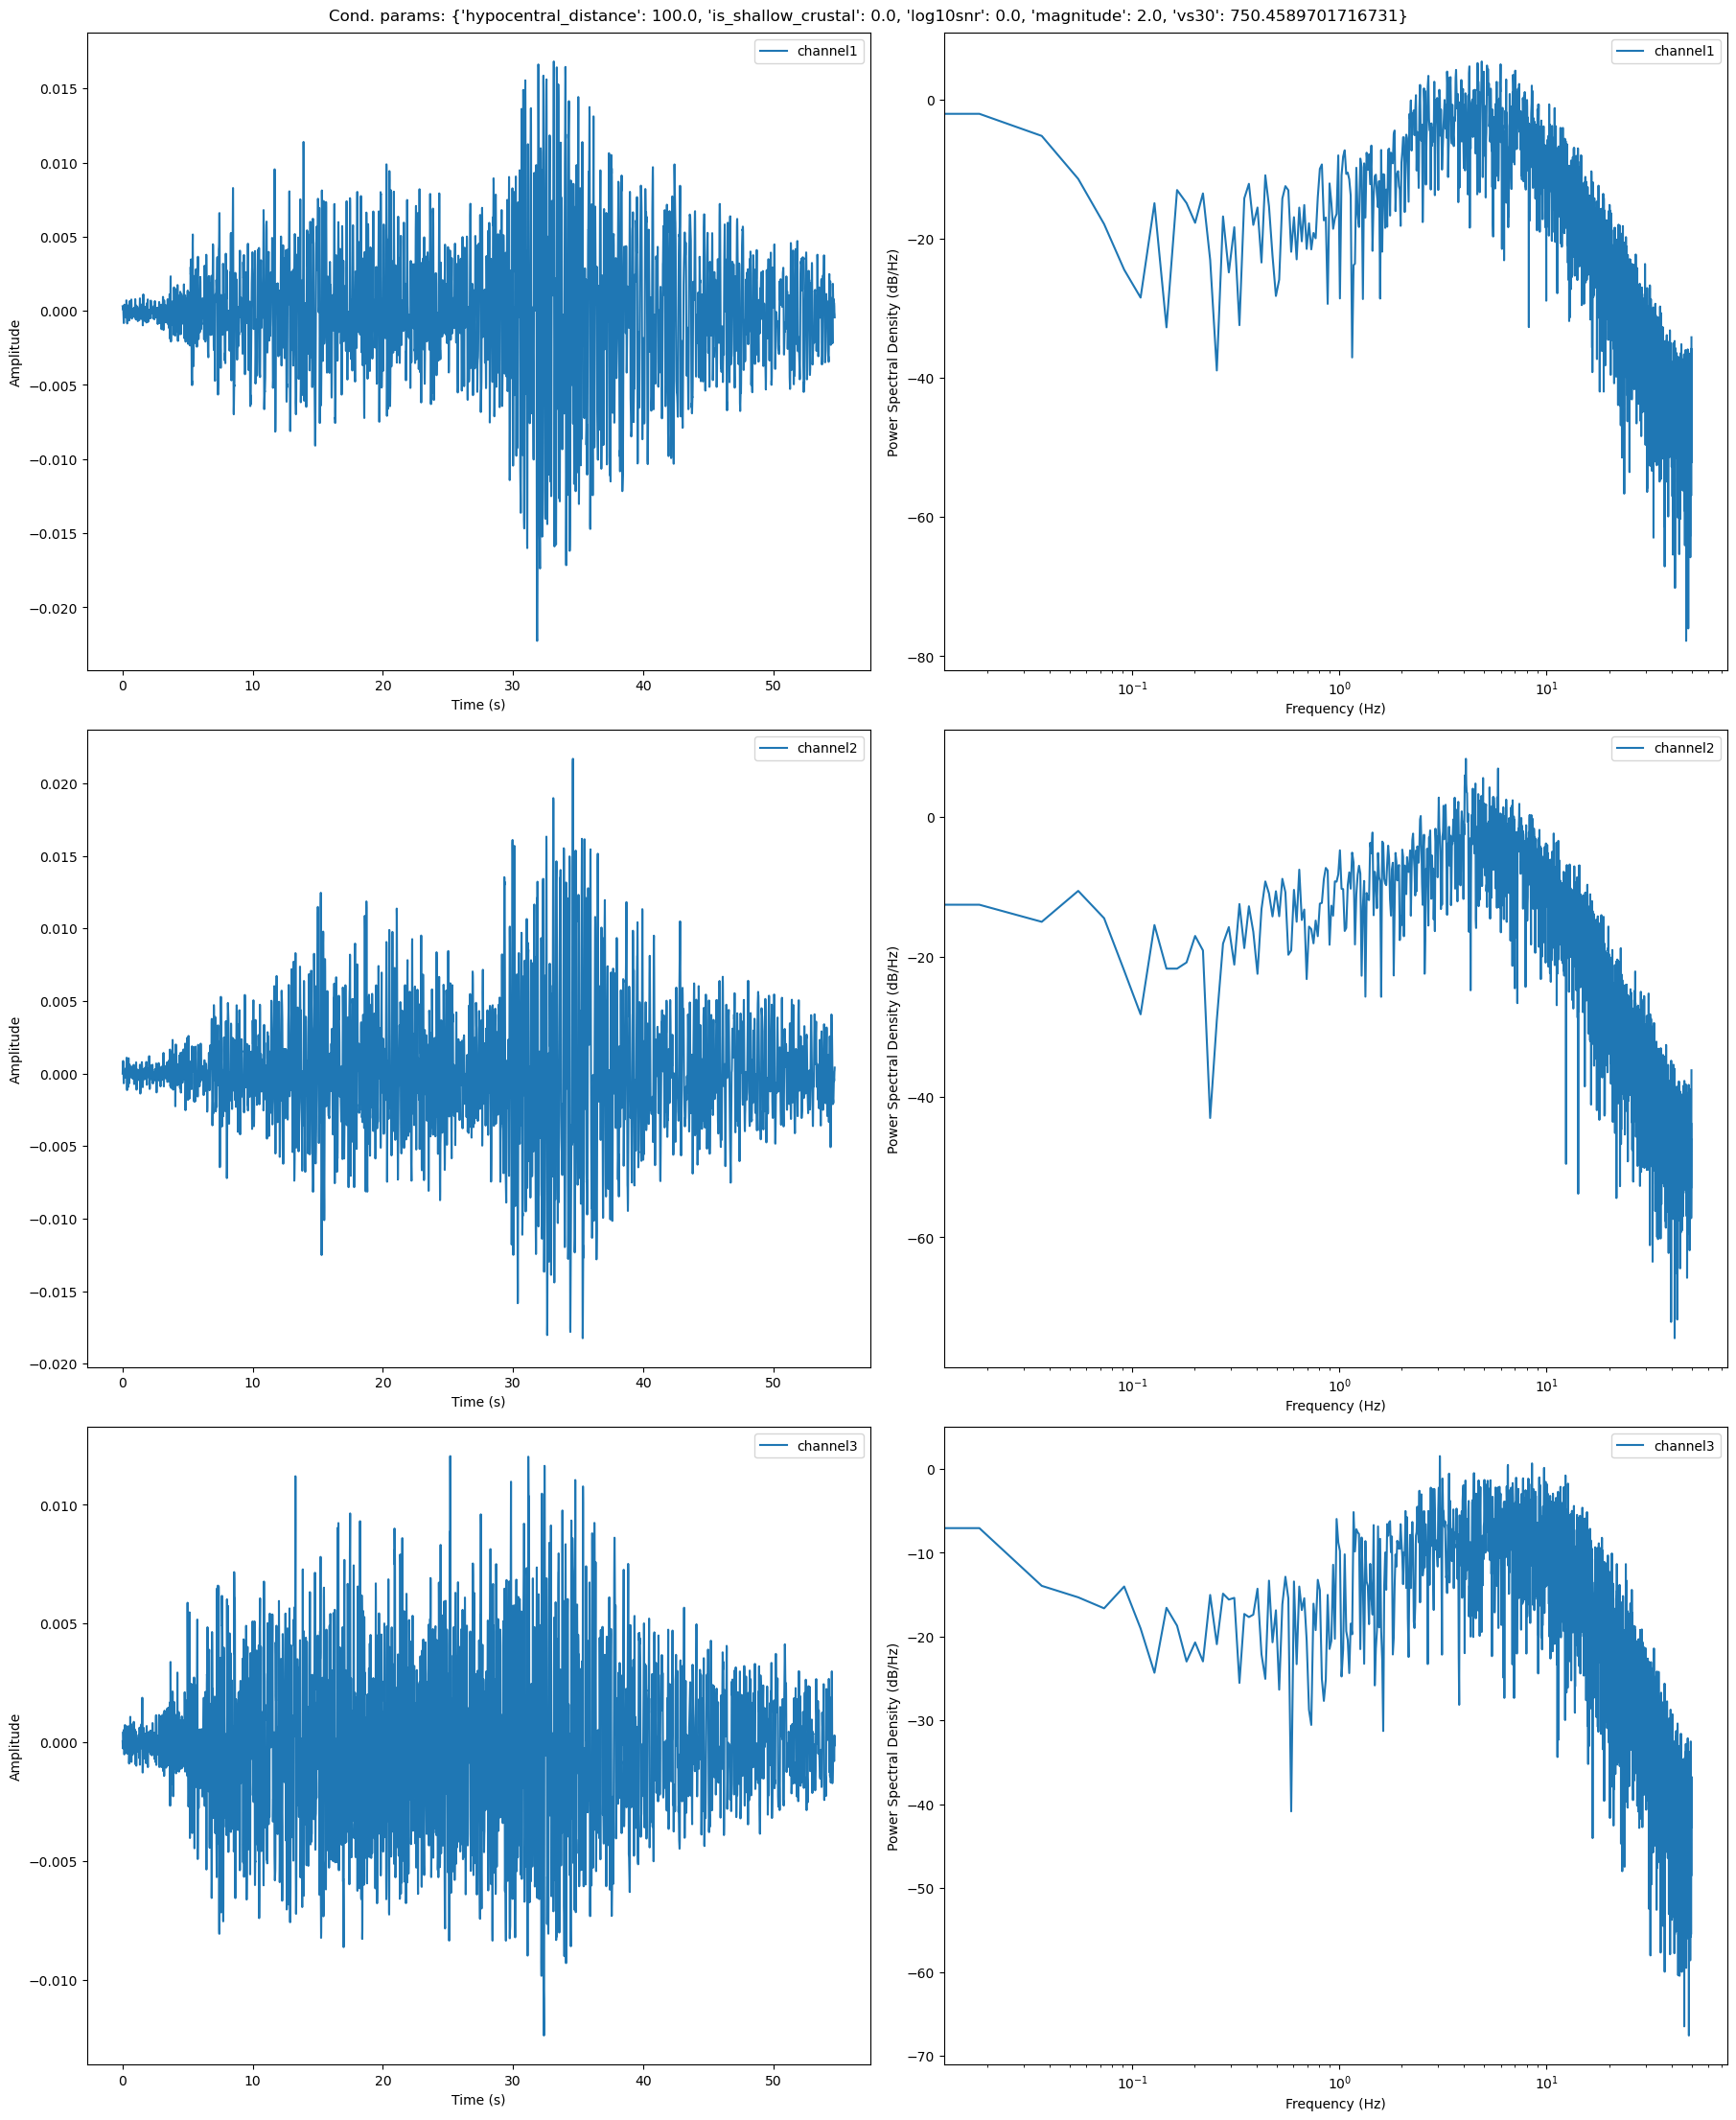

In [8]:
plot_waveform_and_psd(get_samples(data, num_samples=1))

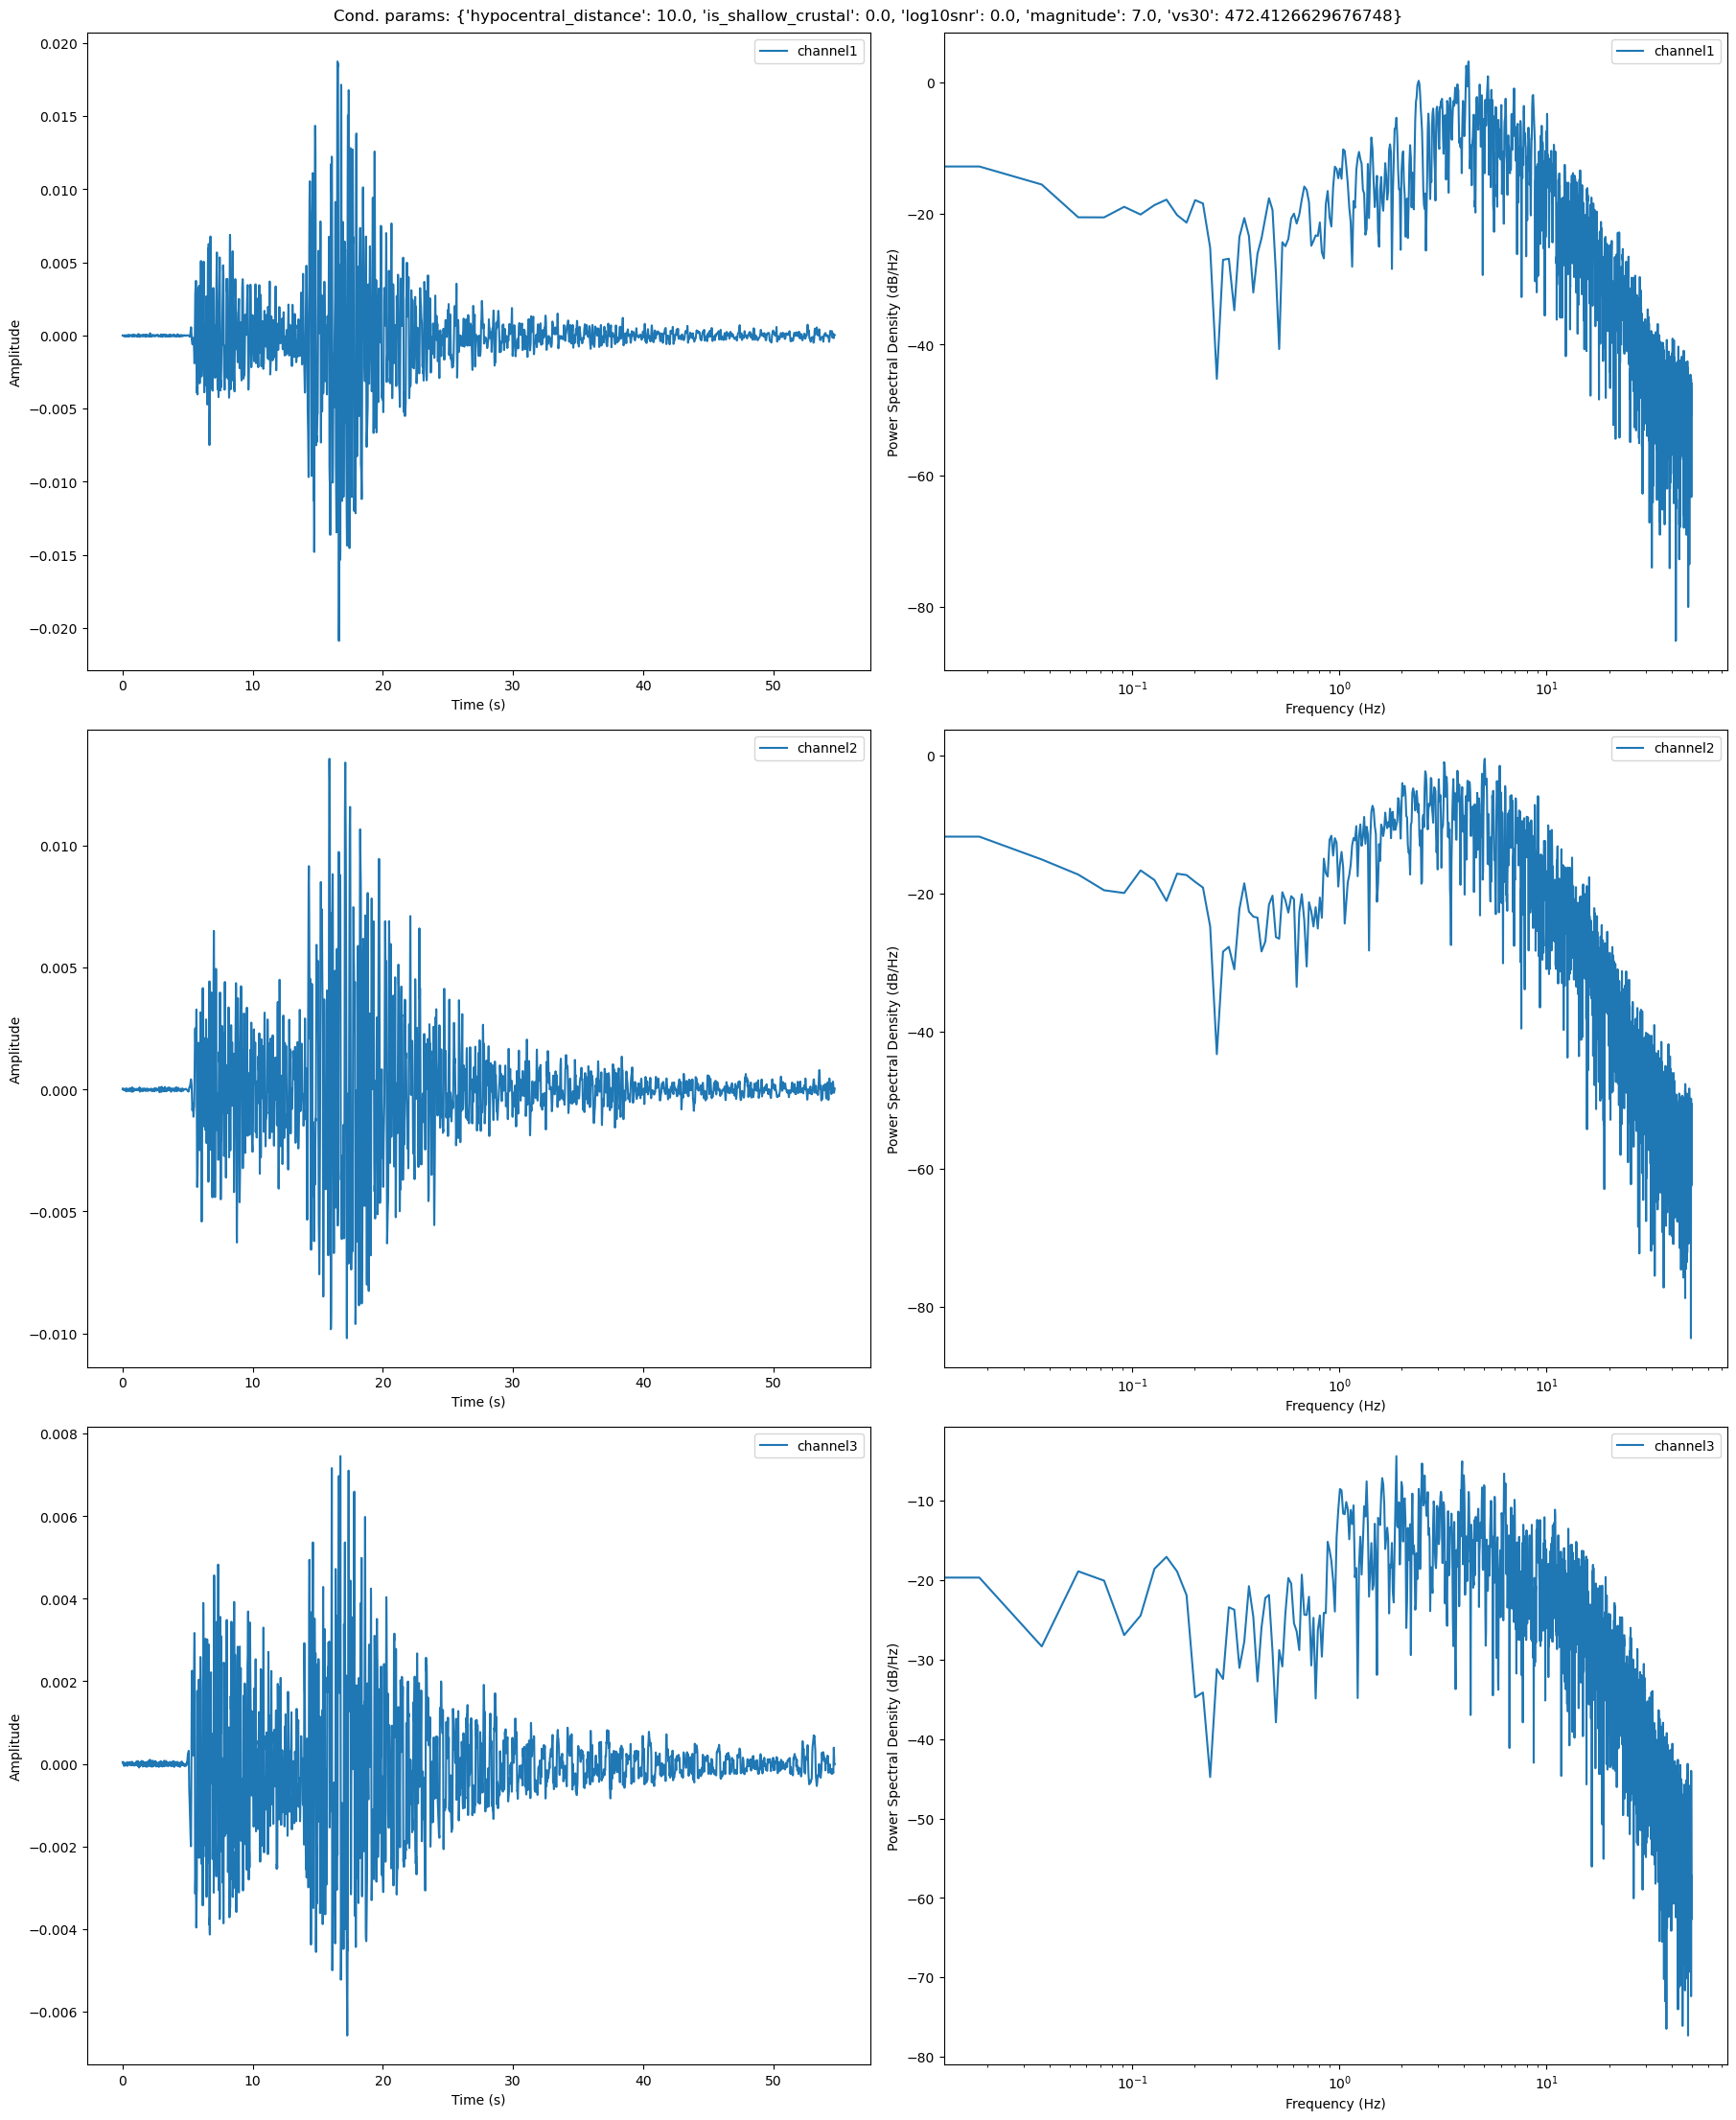

In [9]:
plot_waveform_and_psd(get_samples(data, indexes=[2]))

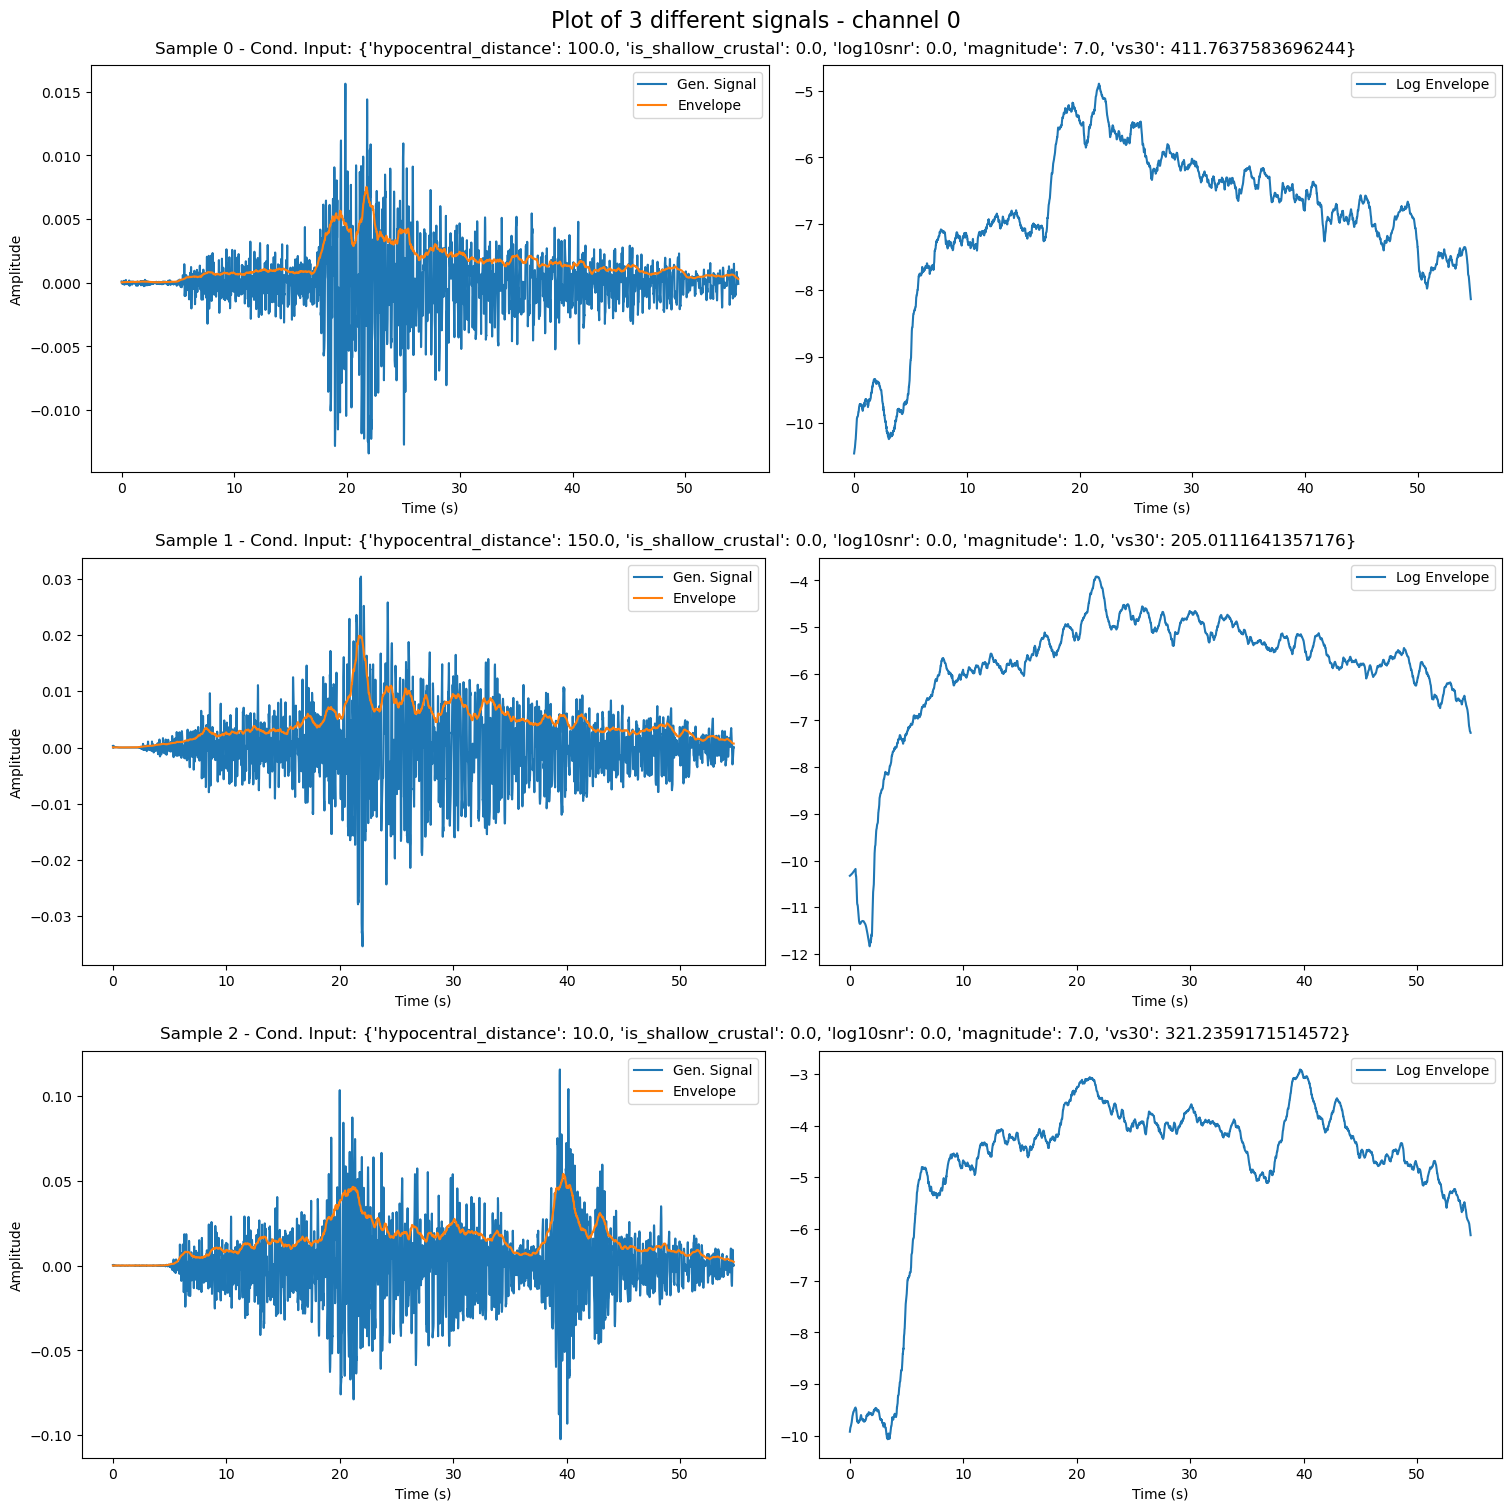

In [10]:
plot_waveforms(get_samples(data, num_samples=3), channel_index=0, plot_log_envelope=True)

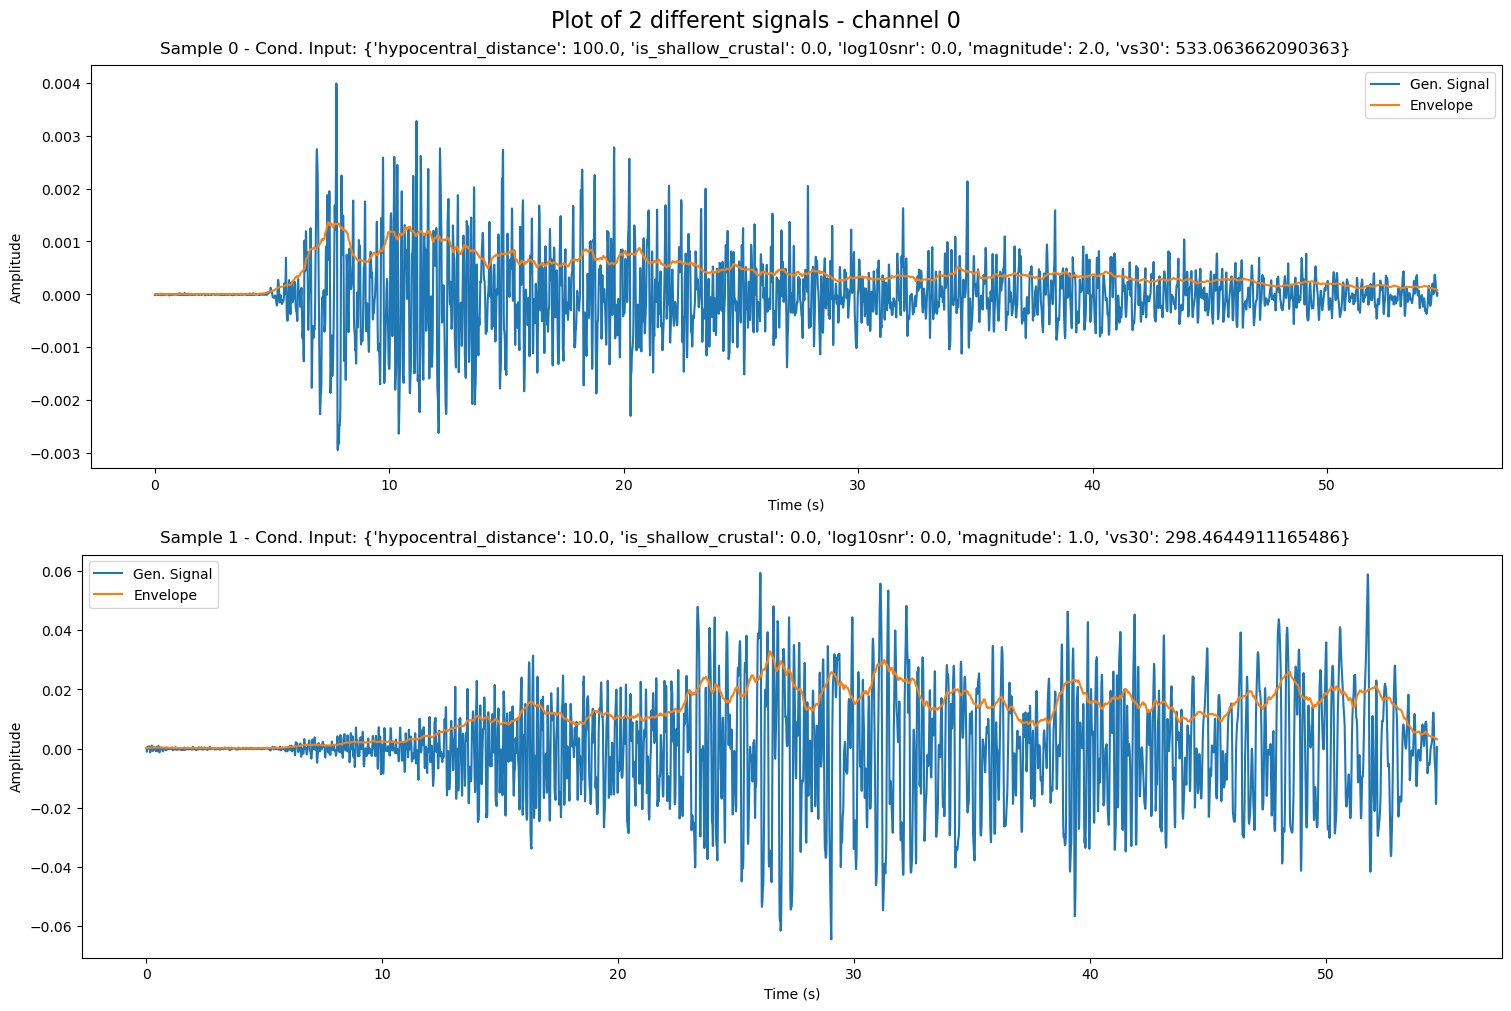

In [11]:
plot_waveforms(get_samples(data, num_samples=2), channel_index=0, plot_log_envelope=False)

## Batch Statistics

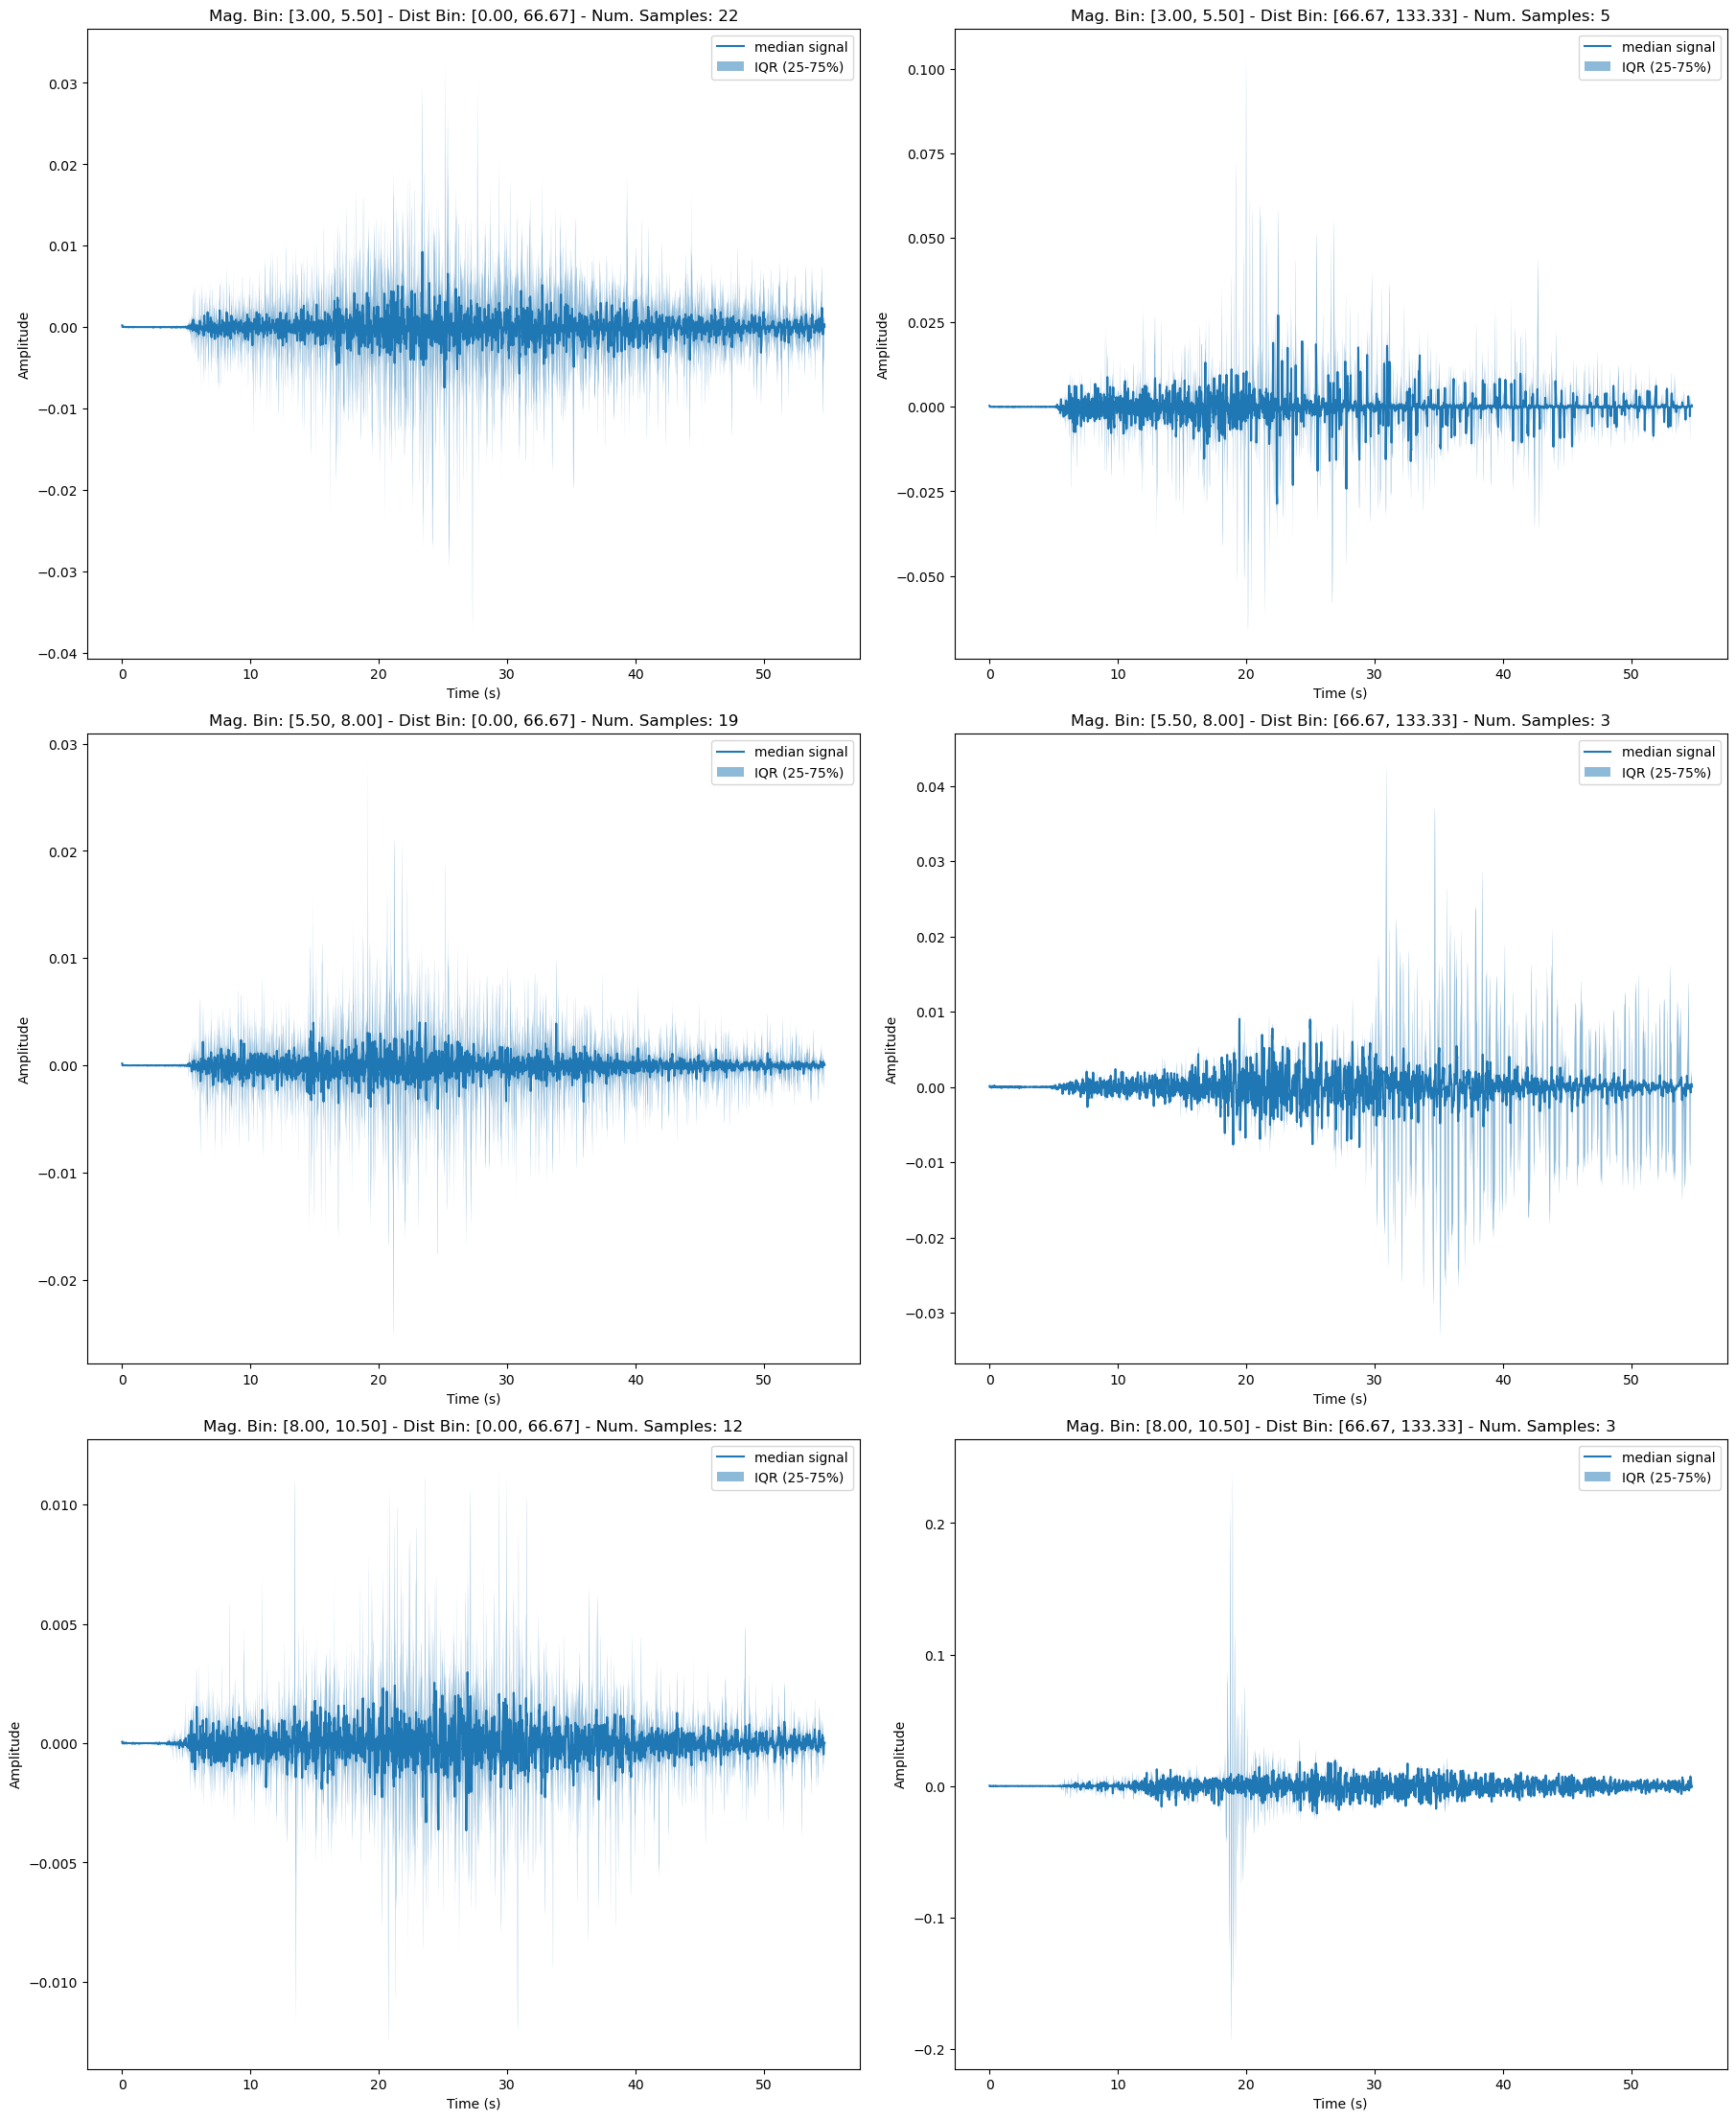

In [12]:
plot_by_bins(data, num_magnitude_bins=2, num_distance_bins=3, plot='waveform')

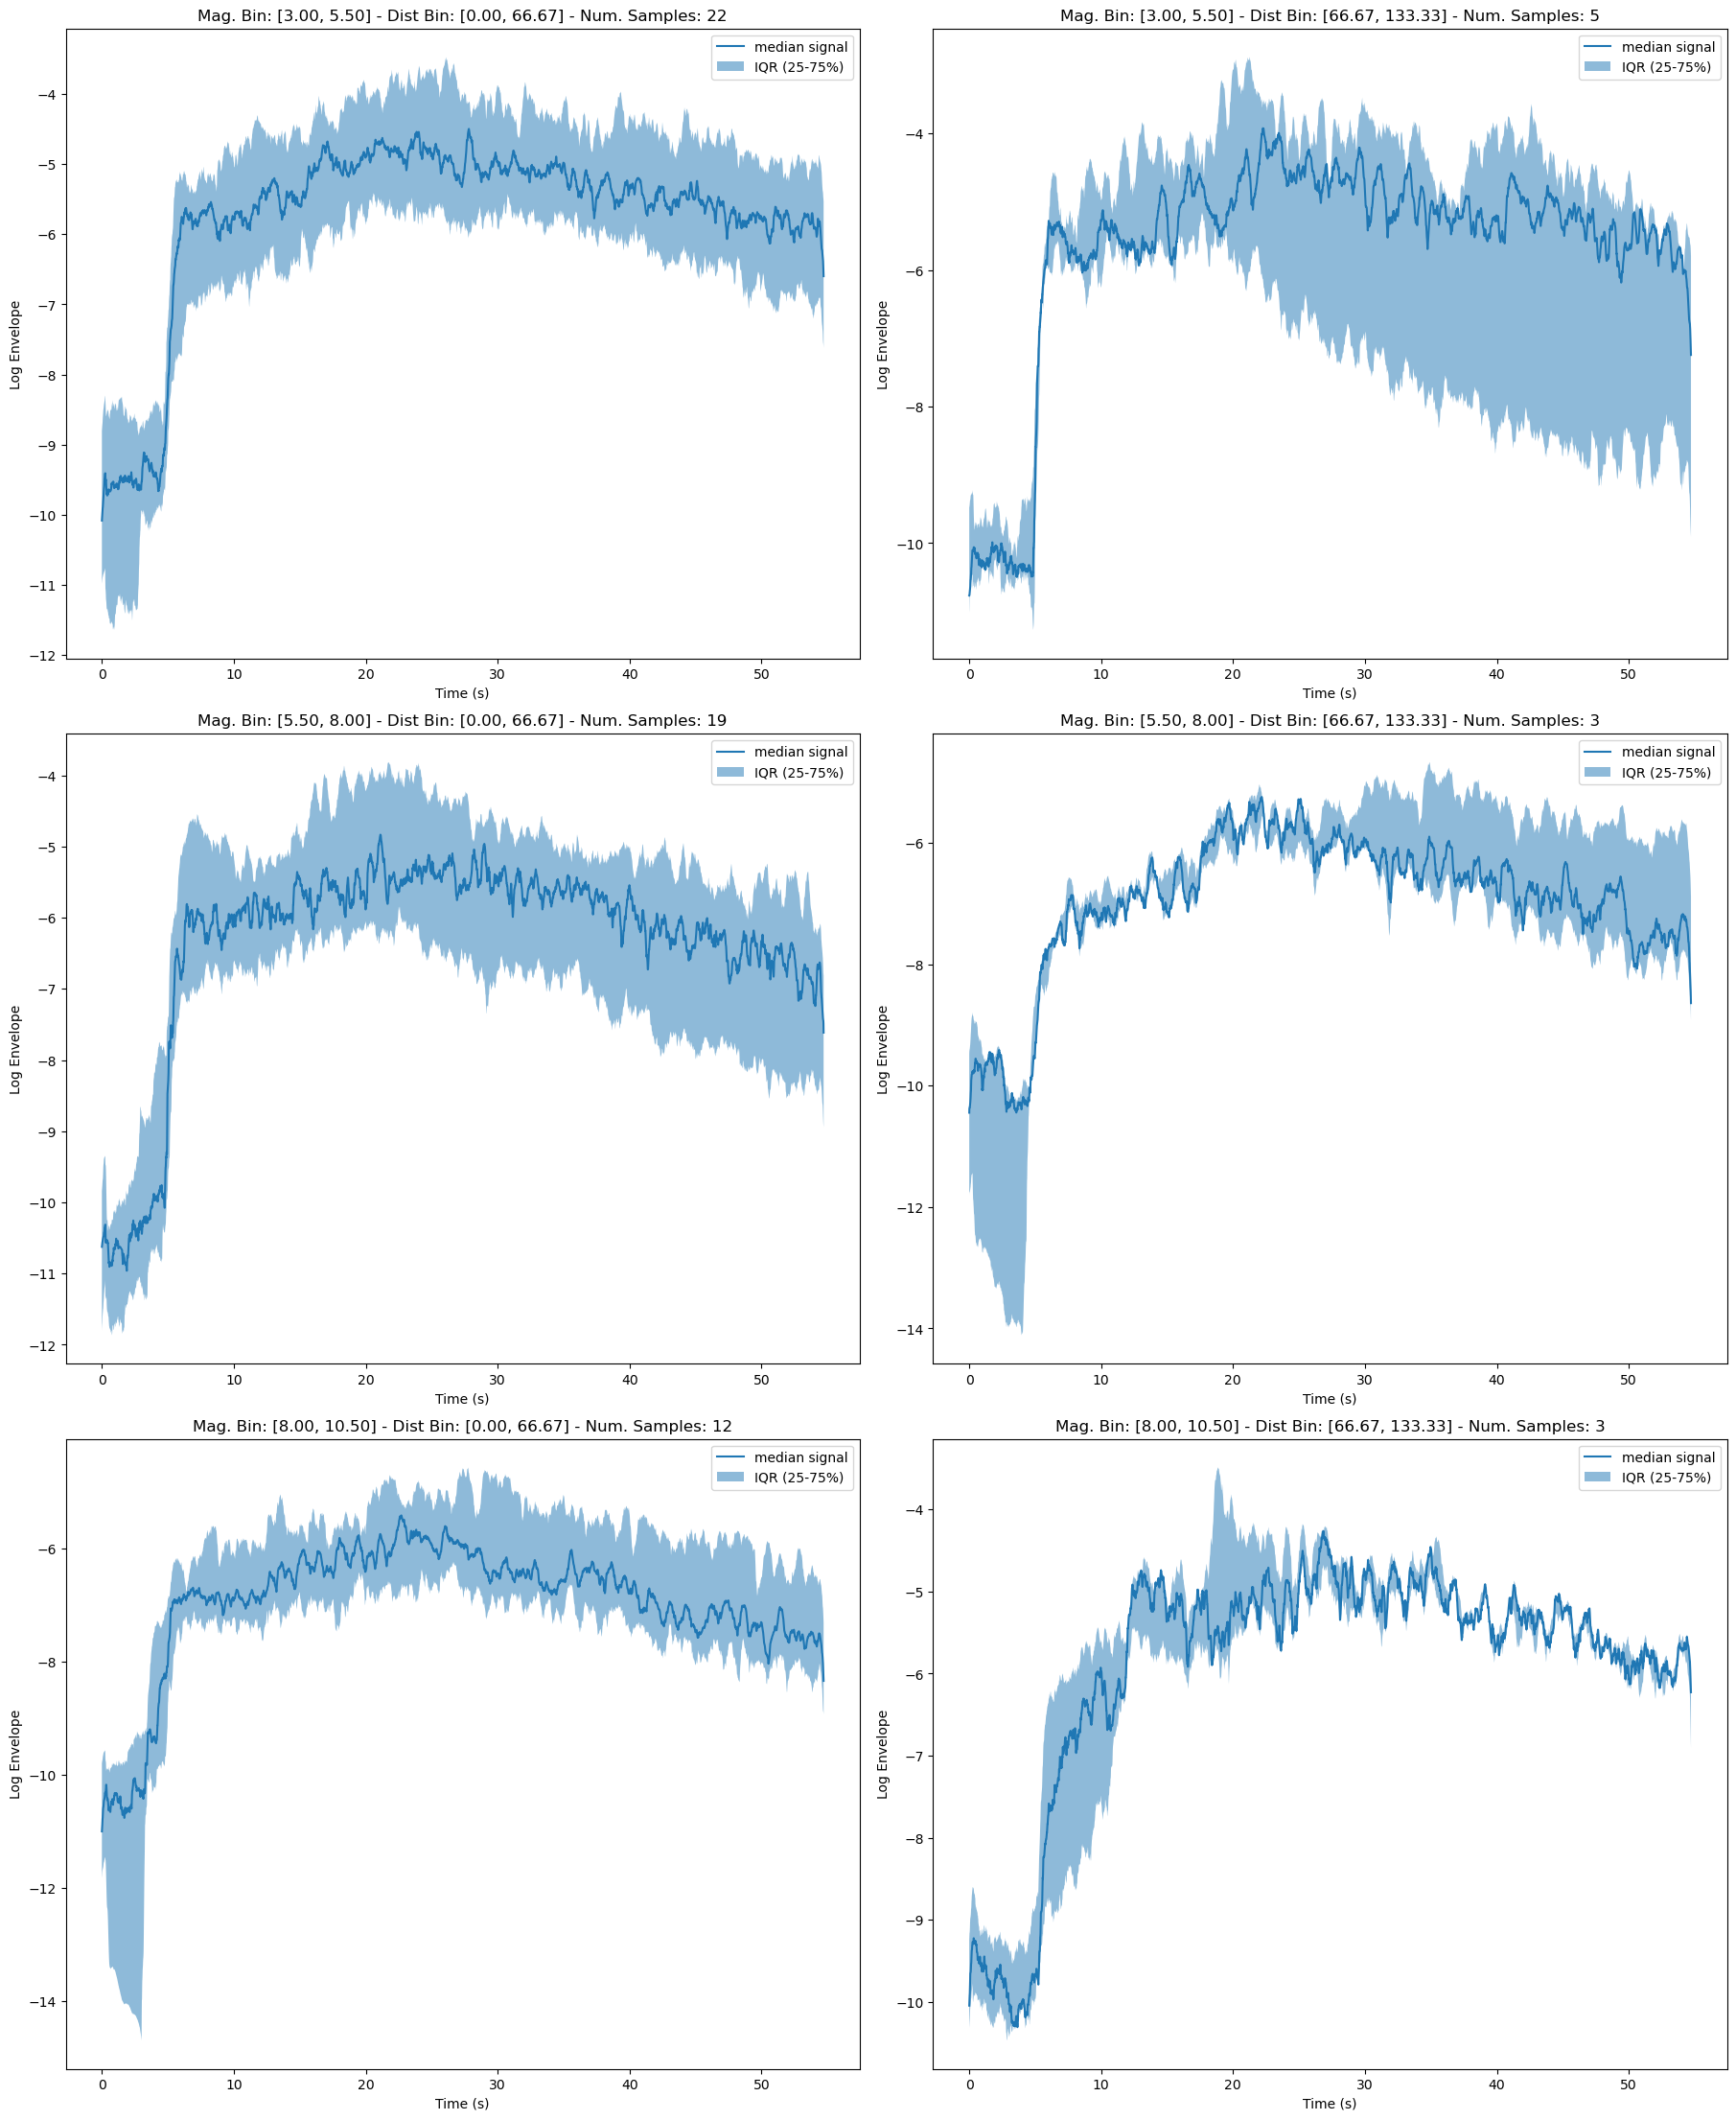

In [13]:
plot_by_bins(data, num_magnitude_bins=2, num_distance_bins=3, plot='envelope')

## Evaluation

In [14]:
# Load Test Data
test_dataset_path = config.datasetdir / config.data_test
with h5py.File(test_dataset_path,'r', locking=False) as test_file:
    test_waveforms = test_file["waveform"][:batch_size*8]
    test_features = test_file["features"][:batch_size*8]


In [15]:
test_waveforms.shape, test_features.shape

((512, 3, 5501), (512, 5))

In [ ]:
# Generate waveforms with the same conditioning parameters of the test data
pred_data = generate_data(model, model_data_repr, batch_size=test_features.shape[0], cond_input=test_features, device=device.type)

pred_data['waveforms'].shape

  6%|▌         | 61/1000 [01:05<16:49,  1.08s/it]

In [ ]:
test_data = {"waveforms": test_waveforms, "cond": test_features}
test_data["waveforms"].shape, test_data["cond"].shape

In [ ]:
plot_log_envelope_bins(distance_bins = [(21.6, 37.1), (39., 48.2), (50., 92.0), (127.2, 144.8)], magnitude_bins = [(3., 5.), (5.1, 6.), (6.1, 7.)], 
                       channel_index=0,
                        test_data = test_data, 
                        data = None, model = model, model_data_representation = model_data_repr)

In [ ]:
from tqdne.metric import PowerSpectralDensity, BinMetric

psd_metrics = [PowerSpectralDensity(fs, channel=channel) for channel in range(pred_data['waveforms'].shape[1])]

for psd_metric in psd_metrics:
    psd_metric.reset()
    psd_metric.update(pred={"generated": pred_data['waveforms']}, target={"representation": test_waveforms[:, :, : pred_data['waveforms'].shape[-1]], "cond": test_features})
    psd_metric.plot().show()
    
    bin_metric = BinMetric(psd_metric, num_mag_bins=3, num_dist_bins=3)
    bin_metric.reset()
    bin_metric.update(pred={"generated": pred_data['waveforms']}, target={"representation": test_waveforms[:, :, : pred_data['waveforms'].shape[-1]], "cond": test_features})
    bin_metric.plot().show()
    
    

In [ ]:
from tqdne.metric import LogEnvelope

log_env_metrics = [LogEnvelope(fs, channel=channel) for channel in range(pred_waveforms.shape[1])]

for log_env_metric in log_env_metrics:
    log_env_metric.reset()
    log_env_metric.update(pred={"generated": pred_waveforms}, target={"representation": test_waveforms[:, :, : pred_waveforms.shape[-1]], "cond": test_features})
    log_env_metric.plot().show()
    
    bin_metric = BinMetric(log_env_metric, num_mag_bins=3, num_dist_bins=3)
    bin_metric.reset()
    bin_metric.update(pred={"generated": pred_waveforms}, target={"representation": test_waveforms[:, :, : pred_waveforms.shape[-1]], "cond": test_features})
    bin_metric.plot().show()
    

In [ ]:
# TODO: widgets do not work

from tqdne.metric import PowerSpectralDensity, BinMetric
import ipywidgets as widgets
from functools import partial

metrics = {"Power Spectral Density": partial(PowerSpectralDensity, fs=config.fs)}

# Create a dropdown for selecting the metric
metric_dropdown = widgets.Dropdown(
    options=metrics.keys(),
    description='Metric:',
)

# Create a slider for selecting the channel
channel_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=2,
    step=1,
    description='Channel:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


# Bin plot checkbox
bin_plot_checkbox = widgets.Checkbox(
    value=False,
    description='Plot bins',
    disabled=False,
    indent=True,
)

# Create a slider for selecting the number of bins
num_bins_slider = widgets.IntSlider(
    value=10,
    min=1,
    max=50,
    step=1,
    description='Num bins:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Function to update the plot
def update_plot(metric_name, bin_plot, num_bins=10, channel=0):
    metric = metrics[metric_name](channel=channel)
    if bin_plot:
        metric = BinMetric(metric, num_mag_bins=num_bins, num_dist_bins=num_bins)

    # Compute the metric
    metric.reset()
    metric.update(pred={"generated": pred_waveforms}, target={"representation": test_waveforms[:, :, : pred_waveforms.shape[-1]], "cond": test_features})
    metric.plot().show()

# Create interactive plot
widgets.interact(update_plot, metric_name=metric_dropdown, channel=channel_slider, bin_plot=bin_plot_checkbox, num_bins=num_bins_slider)



In [ ]:
print('done')